<a href="https://colab.research.google.com/github/raksha-jain/LLM-Powered-Semantic-Search-Personalization-System-for-Internal-Knowledge-Base/blob/main/LLM_Powered_Semantic_Search_%26_Personalization_System_for_Internal_Knowledge_Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/LLM Powered Semantic Search"

collection.tar.gz  qrels.train.tsv  queries.tar.gz


In [ ]:
import pandas as pd
import tarfile
import os

# Define full paths to files
collection_path = "/content/drive/MyDrive/LLM Powered Semantic Search/collection.tar.gz"
queries_path = "/content/drive/MyDrive/LLM Powered Semantic Search/queries.tar.gz"
qrels_path = "/content/drive/MyDrive/LLM Powered Semantic Search/qrels.train.tsv"
extracted_queries_path = "/content/queries.train.tsv" # Define a path for the extracted file

# Load top 100,000 passages for speed
# Assuming collection.tar.gz contains a single file that pd.read_csv can handle
passages = pd.read_csv(collection_path, sep='\t', names=['pid', 'passage'], dtype={'pid': str}, nrows=100000)

# Extract queries.train.tsv from queries.tar.gz
with tarfile.open(queries_path, 'r:gz') as tar:
    # Find the specific file within the tar archive
    for member in tar.getmembers():
        if member.name == 'queries.train.tsv':
            tar.extract(member, path='/content/') # Extract to /content/
            break

# Load the extracted queries file
queries = pd.read_csv(extracted_queries_path, sep='\t', names=['qid', 'query'], dtype={'qid': str})

# Load all qrels
# Assuming qrels.train.tsv is tab-separated with qid and pid in the first and third columns
qrels = pd.read_csv(qrels_path, sep='\t', names=['qid', 'col1', 'pid', 'label'], dtype={'qid': str, 'pid': str})
qrels = qrels[['qid', 'pid', 'label']] # Select relevant columns

# Preview
print("Passages:", passages.shape)
print("Queries:", queries.shape)
print("Qrels:", qrels.shape)

passages.head(2), queries.head(2), qrels.head(2)

Passages: (100000, 2)
Queries: (808731, 2)
Qrels: (532761, 3)


(  pid                                            passage
 0   0  The presence of communication amid scientific ...
 1   1  The Manhattan Project and its atomic bomb help...,
       qid                                     query
 0  121352                            define extreme
 1  634306  what does chattel mean on credit history,
        qid pid  label
 0  1185869   0      1
 1  1185868  16      1)

In [ ]:
print(f"Passages: {passages.shape}")
print(f"Queries: {queries.shape}")
print(f"Relevance Labels: {qrels.shape}")

display(passages.sample(3))
display(queries.sample(3))
display(qrels.sample(3))


Passages: (100000, 2)
Queries: (808731, 2)
Relevance Labels: (532761, 3)


,pid,passage
97512,97512,Statute of Limitations. Statutes of limitation...
27207,27207,"Somewhat like a sauna, the far infrared rays e..."
85344,85344,Flu viruses capable of being transferred to ha...


,qid,query
615303,1016773,which oxygen sensor go bad first
606827,670112,what if i tell child services i don't know who...
344612,176435,dufour effect


,qid,pid,label
227255,961129,3356744,1
297232,768221,4303910,1
113741,1148200,1767288,1


In [ ]:
print(passages.isnull().sum())
print(queries.isnull().sum())
print(qrels.isnull().sum())


pid        0
passage    0
dtype: int64
qid      0
query    0
dtype: int64
qid           0
0        532761
pid      532761
label    532761
dtype: int64


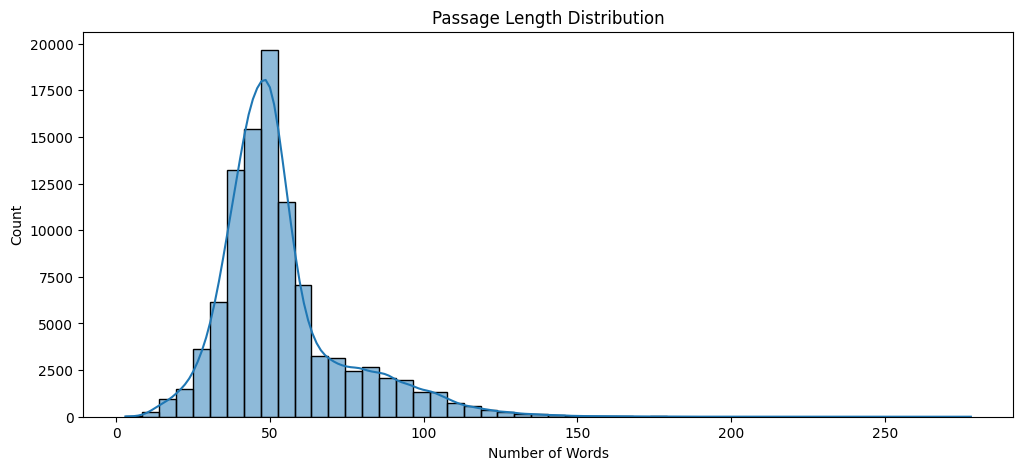

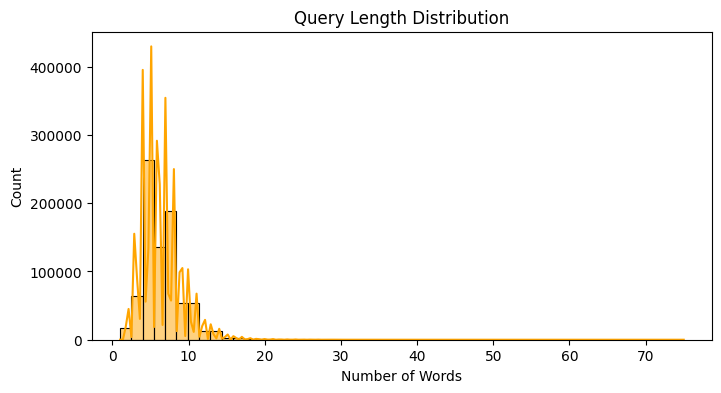

In [ ]:
passages['passage_len'] = passages['passage'].apply(lambda x: len(str(x).split()))
queries['query_len'] = queries['query'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 5))
sns.histplot(passages['passage_len'], bins=50, kde=True)
plt.title('Passage Length Distribution')
plt.xlabel('Number of Words')
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(queries['query_len'], bins=50, kde=True, color='orange')
plt.title('Query Length Distribution')
plt.xlabel('Number of Words')
plt.show()


In [ ]:
# Check label distribution
print(qrels['label'].value_counts())

# Queries with most relevant docs
top_qids = qrels['qid'].value_counts().head(10)
print("Top 10 queries with most relevant passages:\n", top_qids)


Series([], Name: count, dtype: int64)
Top 10 queries with most relevant passages:
 qid
509669\t0\t763169\t1      2
884470\t0\t4496264\t1     2
409466\t0\t1977059\t1     2
126818\t0\t4690511\t1     2
959773\t0\t4068387\t1     2
548004\t0\t8023631\t1     2
122093\t0\t1785921\t1     2
176159\t0\t1893524\t1     2
423024\t0\t2205763\t1     2
1008998\t0\t3651609\t1    2
Name: count, dtype: int64


In [ ]:
# Join queries and passages to see matched examples
merged = qrels.merge(queries, on='qid').merge(passages, on='pid')
display(merged[['qid', 'query', 'pid', 'passage', 'label']].sample(5))

,qid,query,pid,passage,label
2864,270497,how long to expect income tax refund,69213,What to Expect for Refunds in 2015. The IRS is...,1
1925,905660,what time zone is hawaii in,25563,USA and Canada past and future DST schedules h...,1
1649,787392,what is promulgating,43843,Promulgation is the formal proclamation or dec...,1
2155,243873,how long did it take to pay your student loans,86478,Your minimum monthly payment is based on the t...,1
1244,824764,what is the highest iq,56147,"Previously, the highest IQ ever recorded was b...",1


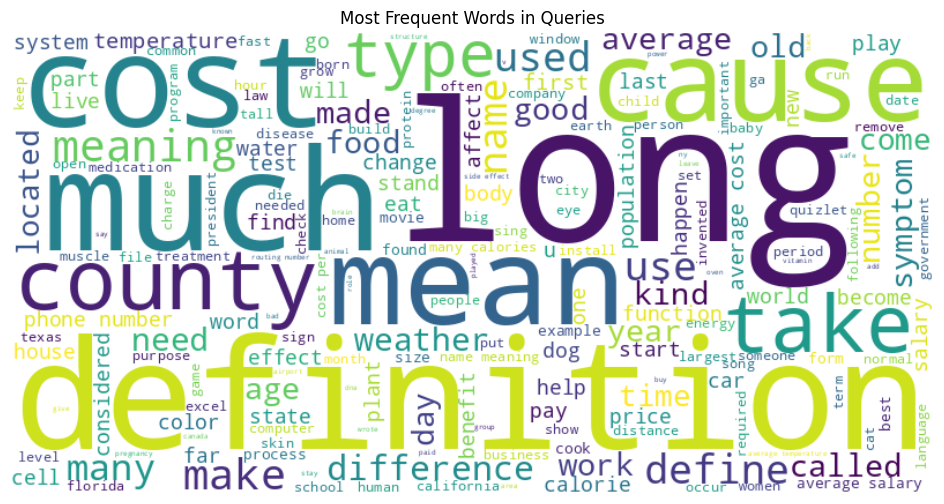

In [ ]:
from wordcloud import WordCloud

all_query_words = ' '.join(queries['query'].values)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_query_words)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Queries')
plt.show()
